In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.data import get_distribution
from labproject.utils import set_seed

set_seed(0)
plt.rcParams['figure.dpi'] = 150


In [3]:
toy_data = get_distribution("toy_2d")
datagen = toy_data()
data = datagen.sample(1000)

def update_toy_mog(datagen,means,covs,weights):
    datagen.means = means
    datagen.covs = covs
    datagen.weights = weights

    datagen.gaussians = [
        torch.distributions.MultivariateNormal(mean, covariance)
        for mean, covariance in zip(datagen.means, datagen.covariances)
    ]    
    return datagen

means2 = torch.Tensor([
            [0.0, 2.5],
            [-1.0, -0.5],
            [1.0, -2.0],
            [-2.0, -1.0],
        ])
            
covariances2 = torch.tensor(
                        [
                            [[1.0, 0.2], [0.2, 1.0]],
                            [[1.0, -0.7], [-0.7, 1.0]],
                            [[1.0, 0.0], [0.0, 1.0]],
                            [[0.5, 0.0], [0.0, 0.5]],
                        ]
                        )
weights2 = torch.tensor([0.3, 0.2, 0.1, 0.5])
datagen2 = update_toy_mog(datagen,means2,covariances2,weights2)
data2 = datagen2.sample(1000)

In [4]:
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

tensor([[2.1614, 4.2141, 5.7055, 2.0034, 7.4913, 4.8794, 4.4335, 5.2918, 2.0234,
         2.3132],
        [1.0383, 1.8318, 3.3747, 1.1247, 5.0778, 2.6363, 1.6756, 3.0079, 0.8178,
         0.7740],
        [0.0609, 2.8801, 4.4264, 1.4048, 5.3957, 2.7919, 2.5926, 3.2028, 0.4049,
         0.2920],
        [1.7768, 3.5335, 5.0160, 1.3217, 7.0831, 4.4964, 3.8264, 4.9046, 1.5265,
         1.8634],
        [1.9722, 0.8979, 2.4432, 1.5200, 5.0491, 2.9121, 1.1665, 3.2116, 1.7089,
         1.7080],
        [1.9818, 0.8942, 2.4310, 1.5699, 4.9896, 2.8618, 1.1065, 3.1584, 1.7298,
         1.7165],
        [3.2032, 2.4213, 3.0358, 3.6411, 2.7947, 1.5464, 1.1749, 1.5427, 3.2601,
         2.9968],
        [3.1501, 1.7525, 2.6581, 1.8034, 6.8736, 4.7903, 2.9118, 5.0956, 2.7253,
         2.9576],
        [1.9892, 1.0879, 2.5046, 1.8880, 4.5493, 2.4478, 0.7246, 2.7305, 1.8273,
         1.7241],
        [2.2002, 5.0501, 6.6018, 3.1890, 6.6666, 4.1625, 4.7059, 4.5443, 2.4662,
         2.4672]])


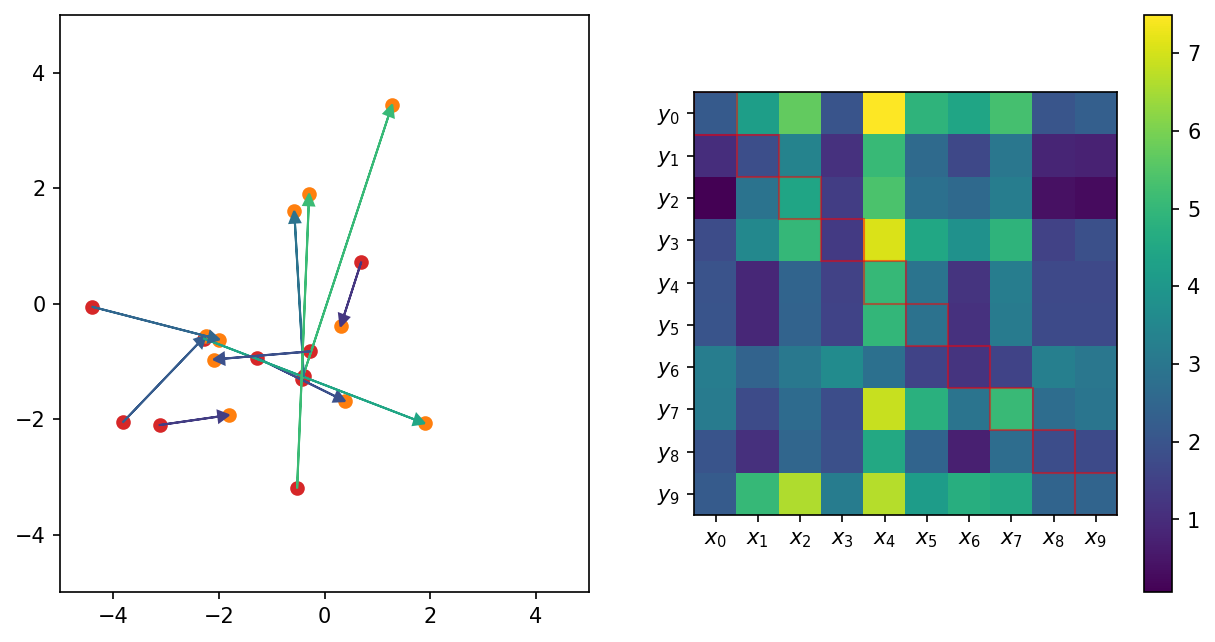

In [5]:
ndata = 10
plot_data = data[:ndata]
plot_data2 = data2[:ndata]
pairdist = torch.cdist(plot_data,plot_data2)
print(pairdist)
fig,axs = plt.subplots(1,2,figsize=(10,5))
colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(ndata)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(ndata)])
for i in range(ndata):
    highlight_cell(i,i,ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2[:, 0], plot_data2[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
for ind,p1,p2 in zip(indices,plot_data,plot_data2):
    axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,ind].item()/pairdist.max().item()))



In [6]:
cmap = cbar.cmap
print(cmap(pairdist[0,0]))

(0.993248, 0.906157, 0.143936, 1.0)


tensor([2, 9, 6, 8, 1, 7, 4, 3, 5, 0])


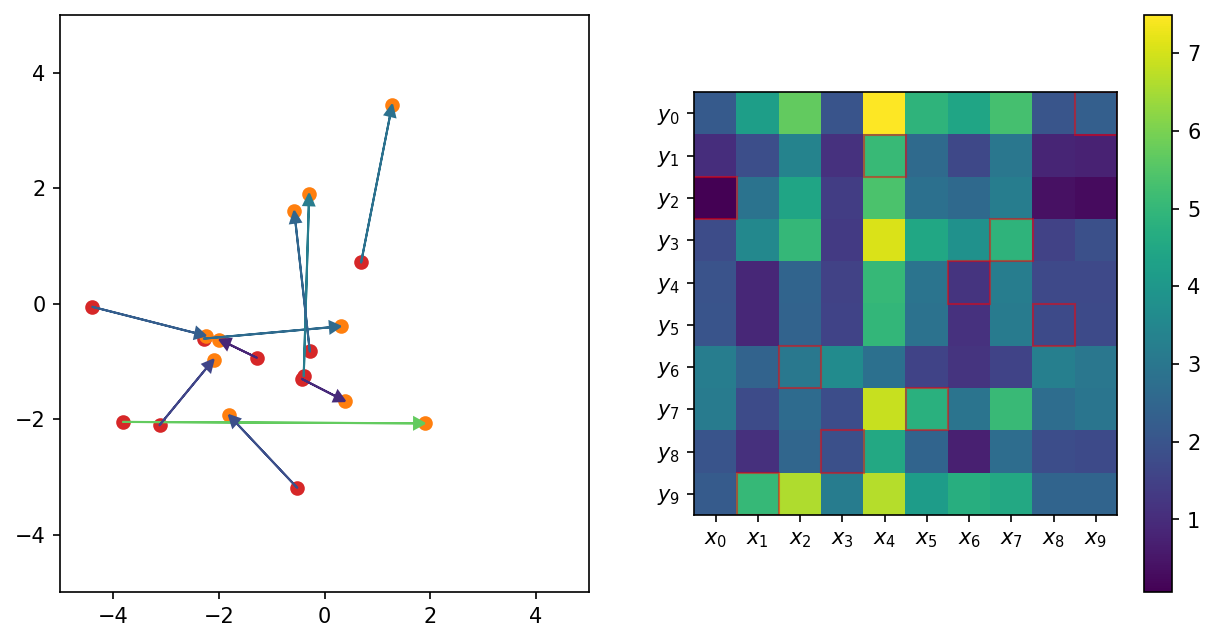

In [7]:
permutation = torch.randperm(plot_data2.size()[0])
print(permutation)
plot_data2_copy = plot_data2[permutation]
#pairdist = torch.cdist(plot_data,plot_data2)

fig,axs = plt.subplots(1,2,figsize=(10,5))

colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(ndata)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(ndata)])
for i in range(ndata):
    highlight_cell(i,permutation[i],ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2_copy[:, 0], plot_data2_copy[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
for ind,p1,p2 in zip(indices,plot_data,plot_data2_copy):
    axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,permutation[ind]].item()/pairdist.max().item()))



tensor([8, 9, 0, 3, 1, 6, 4, 2, 7, 5])


/Users/guymoss/MLS Dropbox/Guy Moss/Guy/Projects/labproject/labproject/metrics/wasserstein_sinkhorn.py:63: UserWarning: Sinkhorn algorithm did not converge after 2000 iterations, final error is 1.8750720959248568e-05
  warnings.warn(f"Sinkhorn algorithm did not converge after {niter} iterations, final error is {err}")


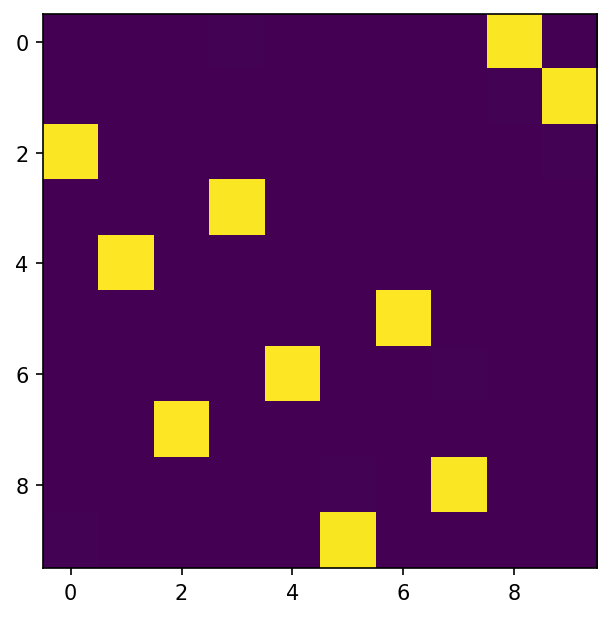

In [8]:
cost,transport = sinkhorn_algorithm(plot_data,plot_data2,epsilon=1e-3,niter=2000)
plt.imshow(transport)
print(transport.argmax(dim=1))

tensor([8, 9, 0, 3, 1, 6, 4, 2, 7, 5])


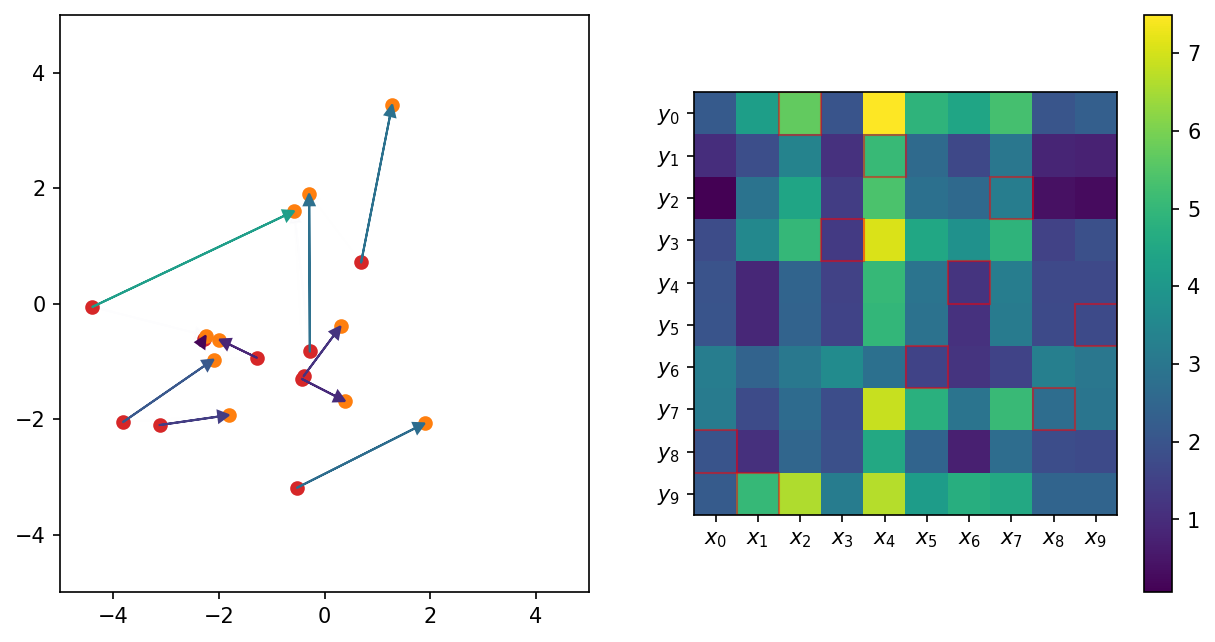

In [9]:
permutation = transport.argmax(dim=1)
print(permutation)
plot_data2_copy = plot_data2[permutation]
# pairdist = torch.cdist(plot_data,plot_data2_copy)

fig,axs = plt.subplots(1,2,figsize=(10,5))

colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(ndata)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(ndata)])
for i in range(ndata):
    highlight_cell(i,permutation[i],ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2_copy[:, 0], plot_data2_copy[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
# indices = torch.arange(0,len(plot_data))
# for ind,p1,p2 in zip(indices,plot_data,plot_data2_copy):
#     axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,permutation[ind]].item()/pairdist.max().item()))
for i in range(ndata):
    for j in range(ndata):
        axs[0].arrow(plot_data[i,0],plot_data[i,1],plot_data2[j,0]-plot_data[i,0],plot_data2[j,1]-plot_data[i,1],head_width=0.2,
                      head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[i,j].item()/pairdist.max().item()),
                      alpha=transport[i,j].item()/transport.max().item())



err tensor(0.0020, dtype=torch.float64)
Sinkhorn iterations:  2000
tensor(2.1304, dtype=torch.float64)
tensor([3, 8, 9, 3, 1, 5, 4, 2, 6, 0])


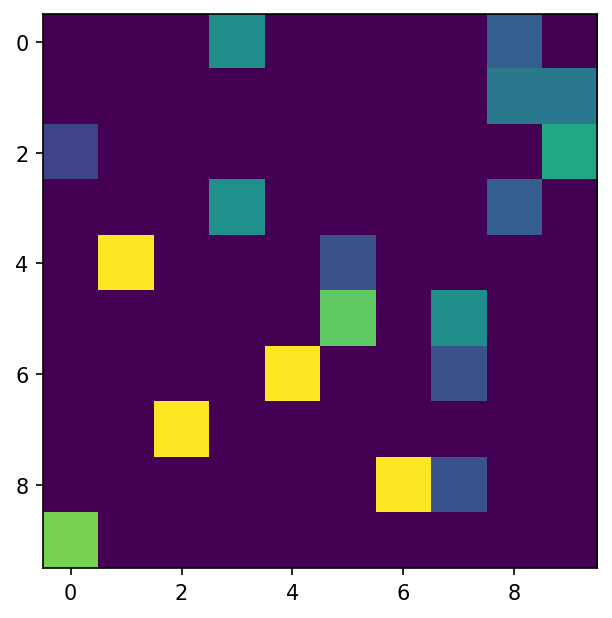

In [10]:
def railway_metric(x,y):
    if torch.abs(torch.dot(x,y) - torch.norm(x) * torch.norm(y)) < 1e-9:
        return torch.norm(x-y)
    else:
        return torch.norm(x) + torch.norm(y)
    
def los_angeles_metric(x,y):
    return torch.norm(x[0]-y[0]) + torch.norm(x[1]) + torch.norm(y[1])

def sinkhorn_algorithm_railway(
    x: torch.Tensor, y: torch.Tensor, epsilon: float = 1e-3, niter: int = 1000, p: int = 2
):
    r"""Compute the sinkhorn approximation to the Wasserstein-p distance between two sets of samples.
    The sinkhorn algorithm adds a small entropy regularization term to the empirical Wasserstein distance.
    Hence this function solves the modified optimal transport problem:

    $$ \text{maximize}_{\pi \in \Pi(a, b)} \sum_\limits_{ij} \pi_{ij}c_{ij} +\epsilon\sum\limits_{ij} \log \pi_{ij}
    \text{s.t} \, \pi 1 = a, \pi^T 1 = b
    $$
    Where $\{c_{ij}\}$ is the cost matrix, $\Pi(a, b)$ is the set of joint distributions with marginals $a$ and $b$.
    In the sample-based setting, all weights $a$ and $b$ are equal to $1/n$.

    Args:
        x (torch.Tensor): tensor of samples from one distribution
        y (torch.Tensor): tensor of samples from another distribution
        epsilon (float): entropy regularization strength
        niter (int): max number of iterations
        p (int): power of distance metric

    Source: https://personal.math.ubc.ca/~geoff/courses/W2019T1/Lecture13.pdf
    Code adapted from https://github.com/gpeyre/SinkhornAutoDiff
    """

    assert len(x.shape) == 2 and len(y.shape) == 2, "x and y must be 2D"
    n, d = x.shape

    # Compute pairwise p-distances
    cost_matrix = torch.zeros((n, n), dtype=torch.double)
    
    for i in range(n):
        for j in range(n):
            cost_matrix[i, j] = railway_metric(x[i].double(), y[j].double())
    # print(cost_matrix)
    # plt.imshow(cost_matrix)
    cost_matrix = torch.cdist(x,y,p=1)
    # cost_matrix /= cost_matrix.norm()
    # print(cost_matrix)
    K = torch.exp(-cost_matrix / epsilon)
    a = torch.ones(n, dtype=torch.double) / n
    b = torch.ones(n, dtype=torch.double) / n

    def MC(u, v):
        r"""Modified cost for logarithmic updates on u,v
        $M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"""
        return (-cost_matrix + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon

    err = 1e6
    actual_niter = 0  # count number of iterations
    thresh = 1e-6
    u, v = torch.zeros(n, dtype=torch.double), torch.zeros(n, dtype=torch.double)
    # print(epsilon)
    # print("log a: ", torch.log(a))
    # Sinkhorn loop
    for actual_niter in range(niter):
        u1 = u.detach().clone()
        v1 = v.detach().clone()
        # print("u1: " , u1)
        # print("diff: " ,torch.logsumexp(MC(u, v), dim=1))
        u = epsilon * (torch.log(a) - torch.logsumexp(MC(u, v), dim=1)) + u
        # print("u: ", u)

        v = epsilon * (torch.log(b) - torch.logsumexp(MC(u, v).T, dim=1)) + v
        # print("v1: " , v1)
        # print("v: ", v)
        err = torch.max((u - u1).abs().sum(), (v1 - v).abs().sum())
        actual_niter += 1
        if err < thresh:
            break
    print("err", err)
    print("Sinkhorn iterations: ", actual_niter)
    U, V = u, v
    transport = torch.exp(MC(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    cost = torch.sum(transport * cost_matrix)  # Sinkhorn cost

    return cost, transport

cost,transport = sinkhorn_algorithm_railway(plot_data,plot_data2,epsilon=1e-3,niter=2000)
print(cost)
plt.imshow(transport)
permutation = transport.argmax(dim=1)
print(permutation)

tensor([3, 8, 9, 3, 1, 5, 4, 2, 6, 0])


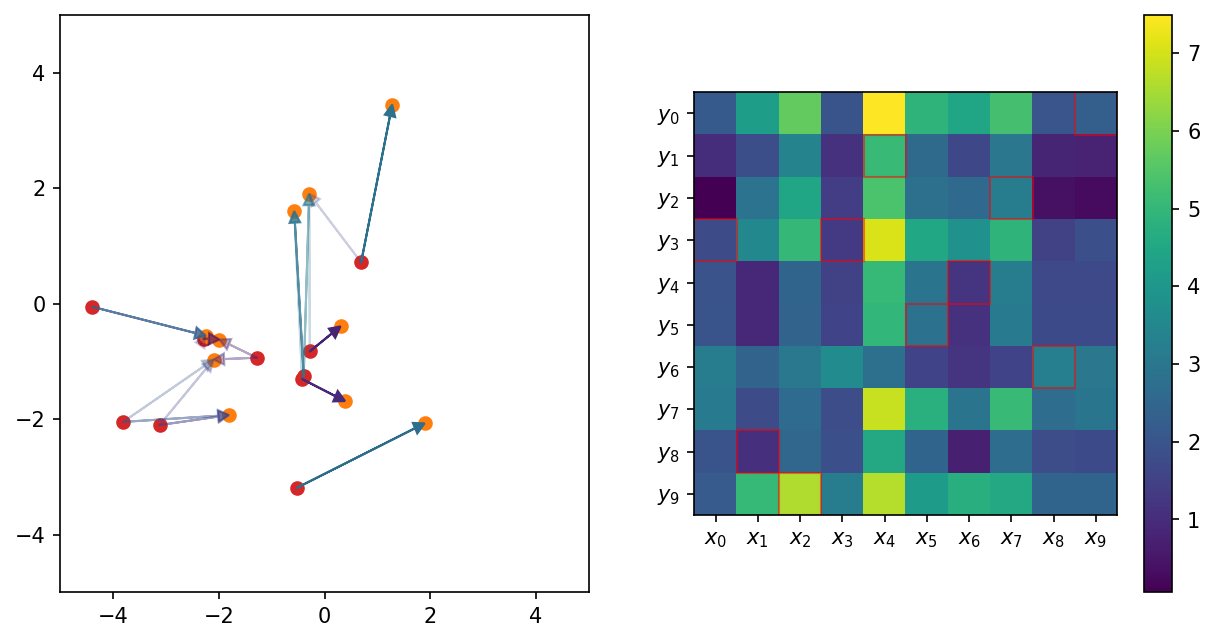

In [11]:
permutation = transport.argmax(dim=1)
print(permutation)
plot_data2_copy = plot_data2[permutation]
# pairdist = torch.cdist(plot_data,plot_data2_copy)

fig,axs = plt.subplots(1,2,figsize=(10,5))

colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(ndata)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(ndata)])
for i in range(ndata):
    highlight_cell(i,permutation[i],ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2[:, 0], plot_data2[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
# for ind,p1,p2 in zip(indices,plot_data,plot_data2_copy):
#     axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,permutation[ind]].item()/pairdist.max().item()))
for i in range(ndata):
    for j in range(ndata):
        axs[0].arrow(plot_data[i,0],plot_data[i,1],plot_data2[j,0]-plot_data[i,0],plot_data2[j,1]-plot_data[i,1],head_width=0.2,
                      head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[i,j].item()/pairdist.max().item()),
                      alpha=transport[i,j].item()/transport.max().item())





tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6029, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2084, 0.0000, 0.0000,
         0.0000],
        [0.4676, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.5494, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3298, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.4121, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.3641, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6906, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3184,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], dtype=tor

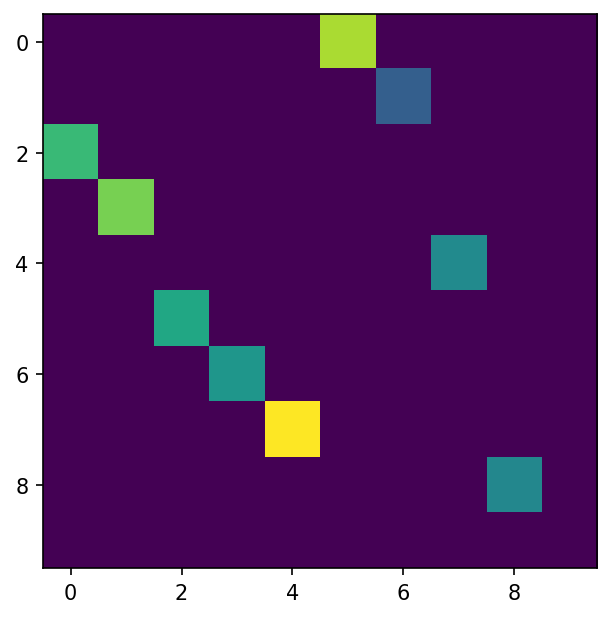

In [12]:
dist,transport = kuhn_transport(plot_data,plot_data2,norm = railway_metric)
print(transport)
plt.imshow(transport)

tensor([5, 6, 0, 1, 7, 2, 3, 4, 8, 0])


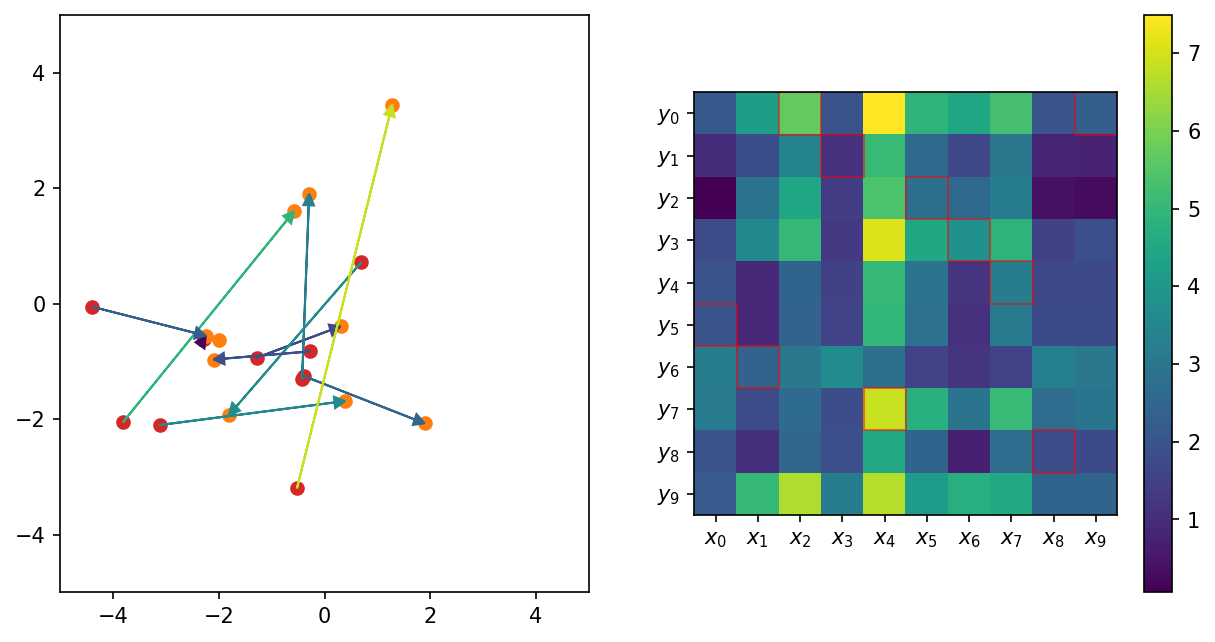

In [13]:
permutation = transport.argmax(dim=1)
print(permutation)
plot_data2_copy = plot_data2[permutation]
# pairdist = torch.cdist(plot_data,plot_data2_copy)

fig,axs = plt.subplots(1,2,figsize=(10,5))

colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(ndata)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(ndata)])
for i in range(ndata):
    highlight_cell(i,permutation[i],ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2[:, 0], plot_data2[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
for ind,p1,p2 in zip(indices,plot_data,plot_data2_copy):
    axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,permutation[ind]].item()/pairdist.max().item()))
# for i in range(ndata):
#     for j in range(ndata):
#         axs[0].arrow(plot_data[i,0],plot_data[i,1],plot_data2[j,0]-plot_data[i,0],plot_data2[j,1]-plot_data[i,1],head_width=0.2,
#                       head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[i,j].item()/pairdist.max().item()),
#                       alpha=transport[i,j].item()/transport.max().item())



